In [ ]:
!pip install timm
!pip install kaggle
!pip install -q datasets transformers
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.7 MB/s eta 0:00:00
  

In [ ]:
# Getting necessary libraries
import timm
import os
import cv2
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split
from pathlib import Path
from PIL import Image

from timeit import default_timer as timer 

# Getting datasets
from torchvision import datasets
from torchvision import transforms

## Getting Datasets


In [ ]:
# from google.colab import files 
# files.upload()


In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d trolukovich/food11-image-dataset
# !unzip food11-image-dataset.zip -d food11-image-dataset

In [ ]:
DATA_PATH = Path("/content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification")
IMAGE_PATH_LIST = list(DATA_PATH.glob("*/*/*.jpg"))
CATEGORIES = sorted(os.listdir(os.path.join(DATA_PATH, "training")))
TRAIN_DIR = DATA_PATH / 'training'
VAL_DIR = DATA_PATH / 'validation'

## Util Functions

In [ ]:
def load_data(data_type):
  images = []
  labels = []
  for idx, category in enumerate(CATEGORIES):
    category_path = os.path.join(DATA_PATH, data_type, category)
    for img_name in os.listdir(category_path):
      img = cv2.imread(os.path.join(category_path, img_name))
      images.append(img)
      labels.append(idx)
  return np.array(images), np.array(labels)


def plot_images(image_paths, n=3, seed=42):
  torch.manual_seed(seed)
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))


  for i in range(n):
    random_idx = torch.randint(len(image_paths), size=[1])
    image_path = image_paths[random_idx]
    image_class = image_path.parent.stem
    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title(f'Image class: {image_class}\nImage Size: ({img.width} x {img.height})')
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()


def plot_transformed_images(image_paths, transform, n=3, seed=42):
  torch.manual_seed(seed)

  for i in range(n):
    fig, axes = plt.subplots(1, 2)

    random_idx = torch.randint(len(image_paths), size=[1])
    image_path = image_paths[random_idx]
    image_class = image_path.parent.stem
    img = Image.open(image_path)

    axes[0].imshow(img)
    axes[0].set_title(f'Image class: {image_class}\nImage Size: ({img.width} x {img.height})')
    axes[0].axis('off')

    transformed_image = transform(img).permute(1, 2, 0)
    axes[1].imshow(transformed_image)
    axes[1].set_title(f'Image class: {image_class}\nImage Size: ({transformed_image.shape})')
    axes[1].axis('off')

  plt.tight_layout()
  plt.show()

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir(os.path.join(DATA_PATH, 'training'))

There are 11 directories and 0 images in '/content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification/training'.
There are 0 directories and 694 images in '/content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification/training/Nasi Lemak'.
There are 0 directories and 994 images in '/content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification/training/Bread'.
There are 0 directories and 429 images in '/content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification/training/Dairy product'.
There are 0 directories and 986 images in '/content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification/training/Egg'.
There are 0 directories and 848 images in '/content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification/training/Fried food'.
There are 0 directories and 1325 images in 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## HuggingFace Model

In [ ]:
# MODEL_NAME = "hf_hub:timm/mobilenetv3_large_100.ra_in1k"
# model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(CATEGORIES))
# summary(model, input_size=[1, 3, 224, 224]) 

In [ ]:
# model.pretrained_cfg

In [ ]:
# data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
# image_transformer = timm.data.create_transform(**data_cfg)

## Pytorch Vision Models

In [ ]:
import torchvision.models as models

weights = models.MobileNet_V3_Large_Weights.DEFAULT
model = models.mobilenet_v3_large(weights=weights)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 74.0MB/s]


In [ ]:
# Replacing final classifier
print(f'Original classifier: \n{model.classifier}')
model.classifier = nn.Sequential(
    nn.Linear(960, 1280),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, out_features=len(CATEGORIES))
)
print(f'Updated classifier: \n{model.classifier}')

try: 
    import torchinfo
except:
    %pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model, input_size=[1, 3, 224, 224]) # do a test pass through of an example input size

Original classifier: 
Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)
Updated classifier: 
Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=11, bias=True)
)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 11]                   --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6   

In [ ]:
model_torch = model.to(device)

## Data Preparation

In [ ]:
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
image_size = 224

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

default_transform = weights.transforms()


train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=default_transform)

test_data = datasets.ImageFolder(root=VAL_DIR, transform=default_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 9060
    Root location: /content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification/training
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 3128
    Root location: /content/drive/Othercomputers/My Laptop/FYP/codes/Classification/training-datasets-classification/validation
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [ ]:
class_names = train_data.classes
class_names

['Bread',
 'Dairy product',
 'Egg',
 'Fried food',
 'Meat',
 'Nasi Lemak',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [ ]:
len(train_data), len(test_data)

(9060, 3128)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

## Visualization

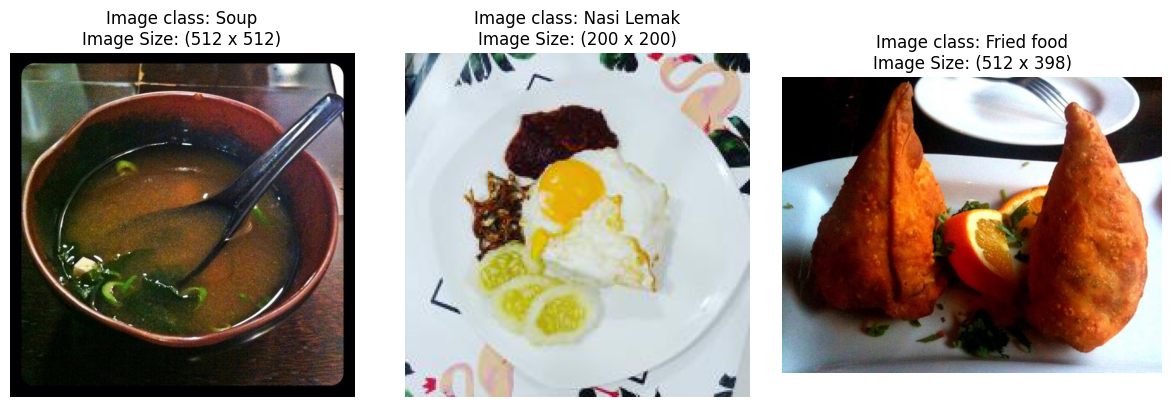

In [ ]:
plot_images(IMAGE_PATH_LIST)

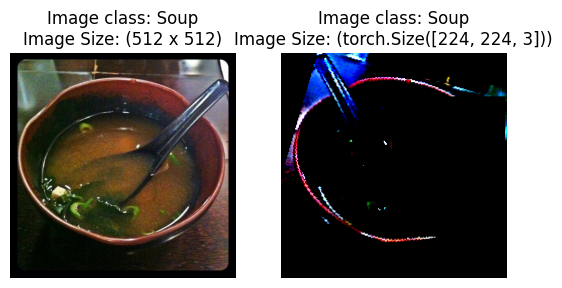

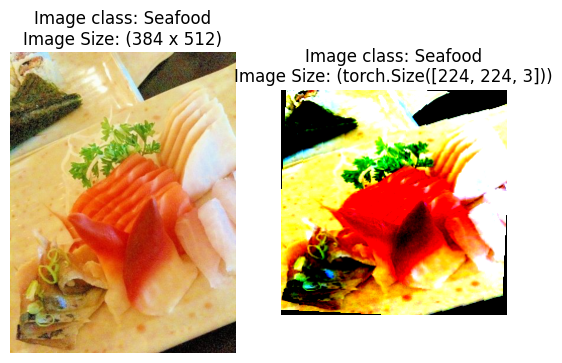

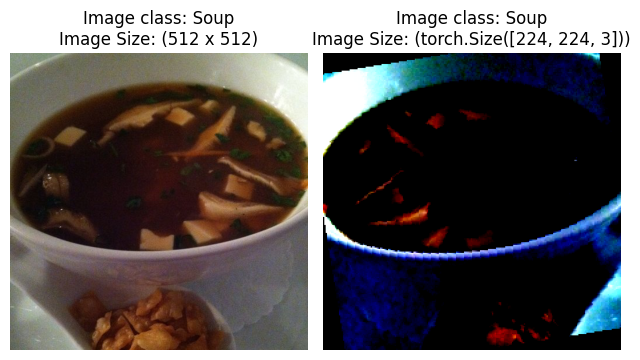

In [ ]:
plot_transformed_images(IMAGE_PATH_LIST, transform=aug_transform)

## Training and Testing Utils

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def save_model(epoch: int, train_acc, test_acc):
  dir = "models"
  isExist = os.path.exists(dir)

  if not isExist:
   os.makedirs(dir)

  print('Saving model...')
  file_name = f'epoch-{epoch}-train-{train_acc:.2f}-test{test_acc:.2f}'
  torch.save(model.state_dict(), os.path.join(dir, file_name))

In [ ]:
from tqdm.auto import tqdm


def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               schedular: torch.optim.lr_scheduler = None):
  
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    if scheduler is not None:
      scheduler.step()
      
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
  
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

early_stopper = EarlyStopper(patience=3, min_delta=10)

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          schedular: torch.optim.lr_scheduler = None,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):

      start_time = timer()

      train_loss, train_acc = train_step(model=model, dataloader=train_dataloader,loss_fn=loss_fn, schedular=schedular, optimizer=optimizer)
      
      test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)
    
      end_time = timer()

      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"Time used: {end_time-start_time:.3f}"
      )
      
      save_model(epoch, train_acc, test_acc)

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      if early_stopper.early_stop(test_loss):             
        break

    return results

## Model Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)
EPOCHS = 30

start_time = timer()

model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      schedular=scheduler,
                      loss_fn=loss_fn, 
                      epochs=EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
x = np.arange(0, EPOCHS)

train_loss, train_acc, test_loss, test_acc = model_results['train_loss'], model_results['train_acc'], model_results['test_loss'], model_results['test_acc']

fig, axes = plt.subplots(1,2, figsize=(10,3))
axes[0].plot(x, train_loss, label='Train Loss')
axes[0].plot(x, test_loss, label='Test Loss')
axes[0].set_title("Epoch vs Loss")
axes[0].legend()

axes[1].plot(x, train_acc, label='Train Acc')
axes[1].plot(x, test_acc, label='Test Acc')
axes[1].set_title("Epoch vs Accuracy")
axes[1].legend()

plt.show()

In [ ]:
def pred_plot(model, image_path, class_names, transform, device):
  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform
  
  model.to(device)

  model.eval()

  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)

    image_pred = model(transformed_image.to(device))

  image_pred_probs = torch.softmax(image_pred, dim = 1)

  predicted_label = torch.argmax(image_pred_probs)

  plt.imshow(img)
  plt.axis(False)
  plt.title(f'Predicted class: {class_names[predicted_label]} | Probs: {image_pred_probs.max():.3f}')

In [ ]:
image_path = '/content/food11-image-dataset/training/Fried food/0.jpg'
pred_plot(model, image_path, class_names, main_transform, device)

## Inferencing

In [ ]:
import torchvision.models as models

weights = models.MobileNet_V3_Large_Weights.DEFAULT
model = models.mobilenet_v3_large(weights=weights)

model.classifier = nn.Sequential(
    nn.Linear(960, 1280),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, out_features=len(CATEGORIES))
)
model = model.to(device)
model.load_state_dict(torch.load('/content/epoch-29-train-0.84-test0.76'))

In [ ]:
pred_plot(model, '/content/easy-and-hearty-vegetable-soup-99538-hero-01-1d3b936ff03144af95ddca7640259c11.jpg', class_names, main_transform, device)